---
syncID: c91d556c8fad4570a33a1aaa550a561d
title: "Plot a Spectral Signature in Python - Tiled Data"
description: "Learn how to extract and plot a spectral profile from a single pixel of a reflectance band using NEON tiled hyperspectral data." 
dateCreated: 2018-07-04 
authors: Bridget Hass
contributors: Donal O'Leary
estimatedTime: 0.5 hours
packagesLibraries: gdal, h5py, requests
topics: hyperspectral-remote-sensing, HDF5, remote-sensing
languagesTool: Python
dataProduct: DP3.30006.001
code1: https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/tutorials/Python/AOP/Hyperspectral/intro-hyperspectral/plot-spectral-signature/plot_spectral_signatures.ipynb
tutorialSeries: intro-hsi-tiles-py-series
urlTitle: plot-spec-sig
---

In this tutorial, we will learn how to extract and plot a spectral profile from a single pixel of a reflectance band in a NEON hyperspectral HDF5 file. 

This tutorial works with the Level 3 <a href="https://data.neonscience.org/data-products/DP3.30006.001" target="_blank">Spectrometer orthorectified surface directional reflectance - mosaic</a> data product. 


<div id="ds-objectives" markdown="1">

### Objectives
After completing this tutorial, you will be able to:

* Plot the spectral signature of a single pixel 
* Remove bad band windows from a spectra
* Use a IPython `widget` to interactively view spectra of various pixels

### Install Python Packages

* **gdal** 
* **h5py**
* **requests**
* **IPython**

### Data

Data and additional scripts required for this lesson are downloaded programmatically as part of the tutorial.

The hyperspectral imagery file used in this lesson was collected over the <a href="http://www.neonscience.org/" target="_blank"> National Ecological Observatory Network's </a> <a href="http://www.neonscience.org/field-sites/serc" target="_blank">Smithsonian Environmental Research Center</a> field site in 2021 and processed at NEON headquarters. 

The entire dataset can be accessed on the <a href="http://data.neonscience.org" target="_blank">NEON Data Portal</a>.

</div>


In this exercise, we will learn how to extract and plot a spectral profile from a single pixel of a reflectance band in a NEON hyperspectral hdf5 file. To do this, we will use the `aop_h5refl2array` function to read in and clean our h5 reflectance data, and the Python package `pandas` to create a dataframe for the reflectance and associated wavelength data.  

## Spectral Signatures

A spectral signature is a plot of the amount of light energy reflected by an object throughout the range of wavelengths in the electromagnetic spectrum. The spectral signature of an object conveys useful information about its structural and chemical composition. We can use these signatures to identify and classify different objects from a spectral image. 

For example, vegetation has a distinct spectral signature.

<figure>
	<a href="https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/graphics/hyperspectral-general/vegetationSpectrum_MarkElowitz.png">
	<img src="https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/graphics/hyperspectral-general/vegetationSpectrum_MarkElowitz.png"></a>
	<figcaption> Spectral signature of vegetation. Source: Mark Elowitz 
	</figcaption>
</figure>

Vegetation has a unique spectral signature characterized by high reflectance in the near infrared wavelengths, and much lower reflectance in the green portion of the visible spectrum. We can extract reflectance values in the NIR and visible spectrums from hyperspectral data in order to map vegetation on the earth's surface. You can also use spectral curves as a proxy for vegetation health. We will explore this concept more in the next lesson, where we will caluclate vegetation indices. 


    
<figure>
	<a href="https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/graphics/hyperspectral-general/ReflectanceCurves_waterVegSoil.png">
	<img src="https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/graphics/hyperspectral-general/ReflectanceCurves_waterVegSoil.png"></a>
	<figcaption> Example spectra of water, green grass, dry grass, and soil. Source: National Ecological Observatory Network (NEON)  
	</figcaption>
</figure>


In [1]:
import os, sys
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

This next function is a handy way to download the Python module and data that we will be using for this lesson. This uses the `requests` package.

In [2]:
# function to download data stored on the internet in a public url to a local file
def download_url(url,download_dir):
    if not os.path.isdir(download_dir):
        os.makedirs(download_dir)
    filename = url.split('/')[-1]
    r = requests.get(url, allow_redirects=True)
    file_object = open(os.path.join(download_dir,filename),'wb')
    file_object.write(r.content)

Download the module from its location on GitHub, add the python_modules to the path and import the neon_aop_hyperspectral.py module.

In [5]:
module_url = "https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/tutorials/Python/AOP/aop_python_modules/neon_aop_hyperspectral.py"
download_url(module_url,'../python_modules')
# os.listdir('../python_modules') #optionally show the contents of this directory to confirm the file downloaded

sys.path.insert(0, '../python_modules')
# import the neon_aop_hyperspectral module, the semicolon supresses an empty plot from displaying
import neon_aop_hyperspectral as neon_hs;

In [6]:
# define the data_url to point to the cloud storage location of the the hyperspectral hdf5 data file
data_url = "https://storage.googleapis.com/neon-aop-products/2021/FullSite/D02/2021_SERC_5/L3/Spectrometer/Reflectance/NEON_D02_SERC_DP3_368000_4306000_reflectance.h5"

In [7]:
# download the h5 data
download_url(data_url,'.\data')

In [8]:
# read the h5 reflectance file (including the full path) to the variable h5_file_name
h5_file_name = data_url.split('/')[-1]
h5_tile = os.path.join(".\data",h5_file_name)

# read in the data using the neon_hs module
serc_refl, serc_refl_md, wavelengths = neon_hs.aop_h5refl2array(h5_tile,'Reflectance')

Reading in  .\data\NEON_D02_SERC_DP3_368000_4306000_reflectance.h5


Optionally, you can view the data stored in the metadata dictionary, and print the minimum, maximum, and mean reflectance values in the tile. In order to ignore NaN values, use `numpy.nanmin/nanmax/nanmean`. 

In [10]:
for item in sorted(serc_refl_md):
    print(item + ':',serc_refl_md[item])

print('\nSERC Tile Reflectance Stats:')
print('min:',np.nanmin(serc_refl))
print('max:',round(np.nanmax(serc_refl),2))
print('mean:',round(np.nanmean(serc_refl),2))

EPSG: 32618
bad_band_window1: [1340 1445]
bad_band_window2: [1790 1955]
ext_dict: {'xMin': 368000.0, 'xMax': 369000.0, 'yMin': 4306000.0, 'yMax': 4307000.0}
extent: (368000.0, 369000.0, 4306000.0, 4307000.0)
no_data_value: -9999.0
projection: b'+proj=UTM +zone=18 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
res: {'pixelWidth': 1.0, 'pixelHeight': 1.0}
scale_factor: 10000.0
shape: (1000, 1000, 426)
source: .\data\NEON_D02_SERC_DP3_368000_4306000_reflectance.h5

SERC Tile Reflectance Stats:
min: -100
max: 15459
mean: 1324.72


For reference, plot the red band of the tile, using splicing, and the `plot_aop_refl` function:

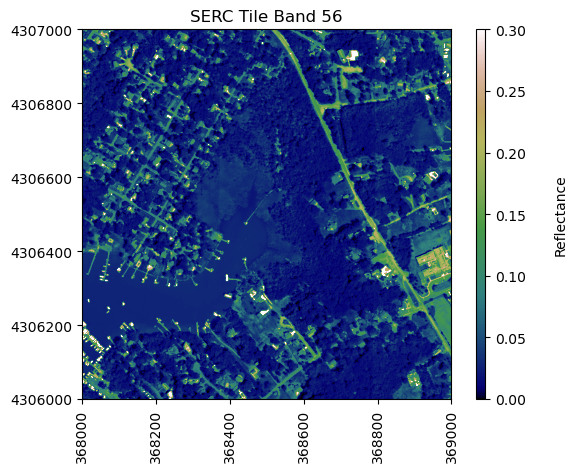

In [11]:
sercb56 = serc_refl[:,:,55]/serc_refl_md['scale_factor']

neon_hs.plot_aop_refl(sercb56,
                      serc_refl_md['extent'],
                      colorlimit=(0,0.3),
                      title='SERC Tile Band 56',
                      cmap_title='Reflectance',
                      colormap='gist_earth')

We can use `pandas` to create a dataframe containing the wavelength and reflectance values for a single pixel - in this example, we'll look at the center pixel of the tile (500,500). To extract all reflectance values from a single pixel, use splicing as we did before to select a single band, but now we need to specify (y,x) and select all bands (using `:`).

In [12]:
serc_pixel_df = pd.DataFrame()
serc_pixel_df['reflectance'] = serc_refl[500,500,:]/serc_refl_md['scale_factor']
serc_pixel_df['wavelengths'] = wavelengths

We can preview the first and last five values of the dataframe using `head` and `tail`:

In [13]:
print(serc_pixel_df.head(5))
print(serc_pixel_df.tail(5))

   reflectance  wavelengths
0       0.0641   383.884003
1       0.0544   388.891693
2       0.0426   393.899506
3       0.0384   398.907196
4       0.0341   403.915009
     reflectance  wavelengths
421       1.4949  2492.149414
422       1.4948  2497.157227
423       0.6192  2502.165039
424       1.4922  2507.172607
425       1.4922  2512.180420


We can now plot the spectra, stored in this dataframe structure. `pandas` has a built in plotting routine, which can be called by typing `.plot` at the end of the dataframe. 

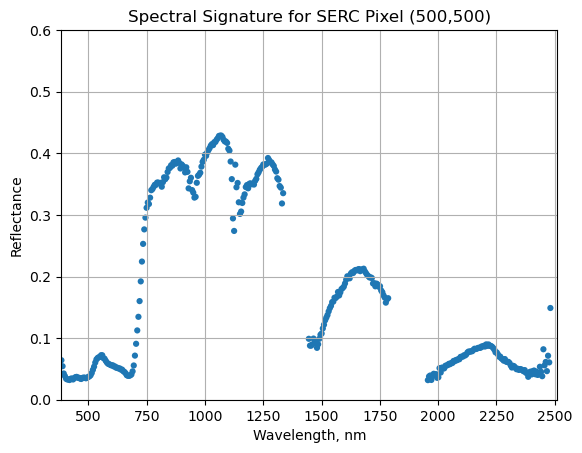

In [15]:
serc_pixel_df.plot(x='wavelengths',y='reflectance',kind='scatter',edgecolor='none')
plt.title('Spectral Signature for SERC Pixel (500,500)')
ax = plt.gca() 
ax.set_xlim([np.min(serc_pixel_df['wavelengths']),np.max(serc_pixel_df['wavelengths'])])
ax.set_ylim(0,0.6)
ax.set_xlabel("Wavelength, nm")
ax.set_ylabel("Reflectance")
ax.grid('on')

##  Water Vapor Band Windows 
We can see from the spectral profile above that there are spikes in reflectance around ~1400nm and ~1800nm. These result from water vapor which absorbs light between wavelengths 1340-1445 nm and 1790-1955 nm. The atmospheric correction that converts radiance to reflectance subsequently results in a spike at these two bands. The wavelengths of these water vapor bands is stored in the reflectance attributes, which is saved in the reflectance metadata dictionary created with `h5refl2array`: 

In [16]:
bbw1 = serc_refl_md['bad_band_window1']; 
bbw2 = serc_refl_md['bad_band_window2']; 
print('Bad Band Window 1:',bbw1)
print('Bad Band Window 2:',bbw2)

Bad Band Window 1: [1340 1445]
Bad Band Window 2: [1790 1955]


Below we repeat the plot we made above, but this time draw in the edges of the water vapor band windows that we need to remove. 

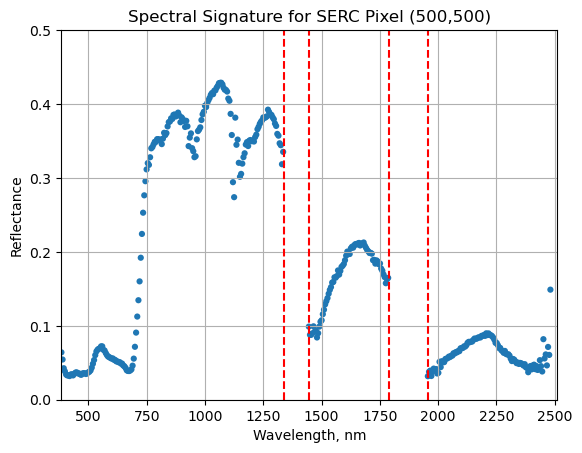

In [18]:
serc_pixel_df.plot(x='wavelengths',y='reflectance',kind='scatter',edgecolor='none');
plt.title('Spectral Signature for SERC Pixel (500,500)')
ax1 = plt.gca(); ax1.grid('on')
ax1.set_xlim([np.min(serc_pixel_df['wavelengths']),np.max(serc_pixel_df['wavelengths'])]); 
ax1.set_ylim(0,0.5)
ax1.set_xlabel("Wavelength, nm"); ax1.set_ylabel("Reflectance")

#Add in red dotted lines to show boundaries of bad band windows:
ax1.plot((1340,1340),(0,1.5), 'r--');
ax1.plot((1445,1445),(0,1.5), 'r--');
ax1.plot((1790,1790),(0,1.5), 'r--');
ax1.plot((1955,1955),(0,1.5), 'r--');

We can now set these bad band windows to `nan`, along with the last 10 bands, which are also often noisy (as seen in the spectral profile plotted above). First make a copy of the wavelengths so that the original metadata doesn't change.

In [19]:
w = wavelengths.copy() #make a copy to deal with the mutable data type
w[((w >= 1340) & (w <= 1445)) | ((w >= 1790) & (w <= 1955))]=np.nan #can also use bbw1[0] or bbw1[1] to avoid hard-coding in
w[-10:]=np.nan;  # the last 10 bands sometimes have noise - best to eliminate
#print(w) #optionally print wavelength values to show that -9999 values are replaced with nan

## Interactive Spectra Visualization
Finally, we can create a `widget` to interactively view the spectra of different pixels along the reflectance tile. Run the cell below, and select different pixel_x and pixel_y values to gain a sense of what the spectra look like for different materials on the ground. 

In [21]:
#define refl_band, refl, and metadata, as copies of the original serc_refl data
refl_band = sercb56
refl = serc_refl.copy()
metadata = serc_refl_md.copy()

from IPython.html.widgets import *

def interactive_spectra_plot(pixel_x,pixel_y):

    reflectance = refl[pixel_y,pixel_x,:]
    
    pixel_df = pd.DataFrame()
    pixel_df['reflectance'] = reflectance
    pixel_df['wavelengths'] = w

    fig = plt.figure(figsize=(15,5))
    ax1 = fig.add_subplot(1,2,1)

    # fig, axes = plt.subplots(nrows=1, ncols=2)
    pixel_df.plot(ax=ax1,x='wavelengths',y='reflectance',kind='scatter',edgecolor='none');
    ax1.set_title('Spectra of Pixel (' + str(pixel_x) + ',' + str(pixel_y) + ')')
    ax1.set_xlim([np.min(wavelengths),np.max(wavelengths)]); 
    ax1.set_ylim([np.min(pixel_df['reflectance']),np.max(pixel_df['reflectance']*1.1)])
    ax1.set_xlabel("Wavelength, nm"); ax1.set_ylabel("Reflectance")
    ax1.grid('on')

    ax2 = fig.add_subplot(1,2,2)
    plot = plt.imshow(refl_band,extent=metadata['extent'],clim=(0,0.1)); 
    plt.title('Pixel Location'); 
    cbar = plt.colorbar(plot,aspect=20); plt.set_cmap('gist_earth'); 
    cbar.set_label('Reflectance',rotation=90,labelpad=20); 
    ax2.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
    rotatexlabels = plt.setp(ax2.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees
    
    ax2.plot(metadata['extent'][0]+pixel_x,metadata['extent'][3]-pixel_y,'s',markersize=5,color='red')
    ax2.set_xlim(metadata['extent'][0],metadata['extent'][1])
    ax2.set_ylim(metadata['extent'][2],metadata['extent'][3])
    
interact(interactive_spectra_plot, pixel_x = (0,refl.shape[1]-1,1),pixel_y=(0,refl.shape[0]-1,1));

interactive(children=(IntSlider(value=499, description='pixel_x', max=999), IntSlider(value=499, description='…